# Load and preprocess data
## Imports

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import random
import sys

# Images
from PIL import Image
from matplotlib import image
from IPython.display import display

## Utility

In [2]:
utility_path = os.path.abspath(os.path.join('..', "utility"))
print(os.listdir(utility_path))
if utility_path not in sys.path:
    sys.path.append(utility_path)
from visualization import plot_landmarks, plot_face, plot_faces
from preprocess import resize_picture, preprocess_picture, preprocess_df
from load_data import load_fk_dataset, extract_target_fk
from augumentation import select_image_part, shift_colors, mirror, apply_select_image_part

['augumentation.py', 'load_data.py', 'preprocess.py', 'visualization.py', '__pycache__']


## Config 

In [3]:
config_path = os.path.abspath(os.path.join('..', "config"))
if config_path not in sys.path:
    sys.path.append(config_path)
from constant import MAX_IMG_SIZE, IMG_SIZE, SMALL_DS_SIZE

## Collected data overview

In [4]:
data_path = os.path.join(os.getcwd(), "..", "data")
print(os.listdir(data_path))

['Face Images with Marked Landmark Point', 'Facial Keypoints', 'X_FK.npy', 'X_small.npy', 'Y_FK.npy', 'Y_small.npy']


## Facial Keypoints dataset
### Load data

In [5]:
fk_data_path = os.path.join(data_path, "Facial Keypoints")
print(os.listdir(fk_data_path))
labels_df = load_fk_dataset(fk_data_path)
print(labels_df.head(2))

['test', 'test_frames_keypoints.csv', 'training', 'training_frames_keypoints.csv']
                                           file_name     0     1     2      3  \
0  C:\Users\ciche\OneDrive\Pulpit\solvro\Face-Cen...  45.0  98.0  47.0  106.0   
1  C:\Users\ciche\OneDrive\Pulpit\solvro\Face-Cen...  41.0  83.0  43.0   91.0   

      4      5     6      7     8  ...   126    127   128    129   130    131  \
0  49.0  110.0  53.0  119.0  56.0  ...  83.0  119.0  90.0  117.0  83.0  119.0   
1  45.0  100.0  47.0  108.0  51.0  ...  85.0  122.0  94.0  120.0  85.0  122.0   

    132    133   134    135  
0  81.0  122.0  77.0  122.0  
1  83.0  122.0  79.0  122.0  

[2 rows x 137 columns]


### Quick glance at avaible data

RGBA
(260, 323)


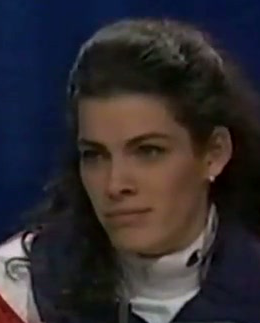

In [6]:
file_name = labels_df['file_name'][125]
img = Image.open(file_name)
print(img.mode)
print(img.size)
display(img)

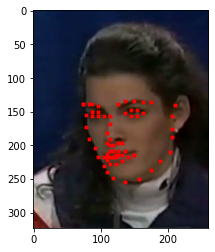

In [7]:
# Convert into RGB 
background = Image.new("RGB", img.size, (255, 255, 255))
background.paste(img, mask=img.split()[3])
img = background
data = np.asarray(img)
labels = labels_df.iloc[125,1:]
# extract markers coordinates
markers = [labels[i: i+2]  for i in range(0, len(labels), 2)]
plot_landmarks(data, markers)

### Target

109.0 182.0
Our target will be 30-th point


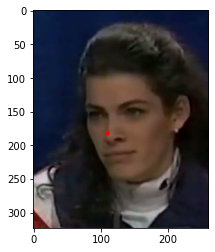

In [8]:
i = 29
fig, ax = plt.subplots(sharex=True,sharey=True)
ax.imshow(data[:,:,:])
print(markers[i][0], markers[i][1])
ax.scatter(markers[i][0], markers[i][1], marker='X', c='r', s=10)
print("Our target will be 30-th point")

In [9]:
labels_df = extract_target_fk(labels_df)
print(labels_df.head(2))

                                           file_name  x_coord  y_coord
0  C:\Users\ciche\OneDrive\Pulpit\solvro\Face-Cen...     79.0    102.0
1  C:\Users\ciche\OneDrive\Pulpit\solvro\Face-Cen...     83.0    107.0


### Pictures shapes overview

In [10]:
sizes = {
    'x':{i:0 for i in range(MAX_IMG_SIZE)},
    'y':{i:0 for i in range(MAX_IMG_SIZE)}
}
for index, row in labels_df.iterrows():
    file_name = row['file_name']
    img = Image.open(file_name)
    sizes['x'][img.size[0]] += 1
    sizes['y'][img.size[1]] += 1

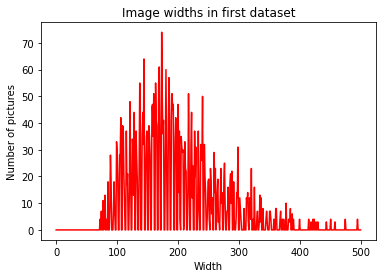

In [11]:
# Its helpfull to visulize avalible sizes
x_axis = [i for i in range(MAX_IMG_SIZE)]
x_sizes = [sizes['x'][i] for i in range(MAX_IMG_SIZE)]
plt.plot(x_axis, x_sizes, 'r-')
plt.title("Image widths in first dataset")
plt.ylabel('Number of pictures')
plt.xlabel('Width')
plt.show()

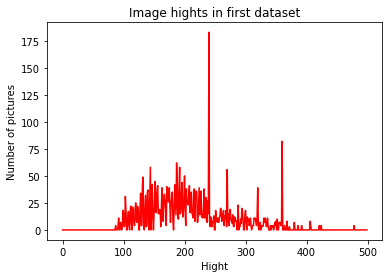

In [12]:
y_sizes = [sizes['y'][i] for i in range(MAX_IMG_SIZE)]
plt.plot(x_axis, y_sizes, 'r-')
plt.title("Image hights in first dataset")
plt.ylabel('Number of pictures')
plt.xlabel('Hight')
plt.show()

### Preprocess data

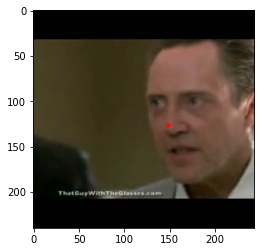

In [13]:
# Example 1
row = labels_df.iloc[9,:]
file_name = row['file_name']
x_cord = row['x_coord']
y_cord = row['y_coord']
img = Image.open(file_name)
plot_face(np.asarray(img), coordinates=[x_cord, y_cord])

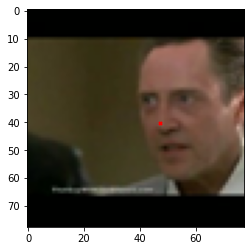

In [14]:
img_arr, x_scale, y_scale = preprocess_picture(file_name, new_size=IMG_SIZE)
plot_face(img_arr, coordinates=[x_cord * x_scale, y_cord * y_scale])

## Save pictures as numpy array

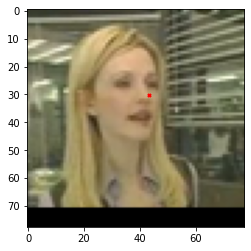

In [15]:
X, Y = preprocess_df(labels_df, img_size=IMG_SIZE)

plot_face(X[33, :], [Y[33, 0], Y[33, 1]])

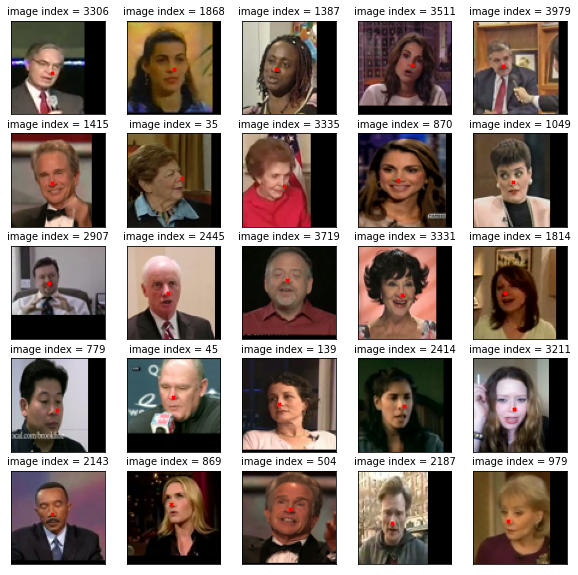

In [16]:
plot_faces(X, Y)

### Data Augmentation

#### Select part of image
In our dataset, most examples have face center, well in the center of the image... Lets try to fix that!

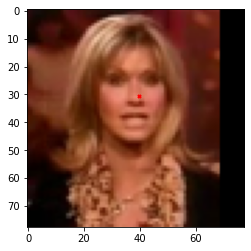

In [17]:
# Example 1
plot_face(X[500], Y[500])

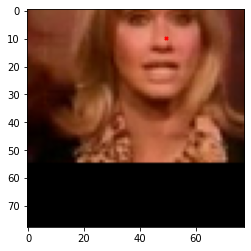

In [33]:
i = 500
suc, img_arr, coord = select_image_part(labels_df['file_name'][i], [labels_df['x_coord'][i], labels_df['y_coord'][i]], min_size=IMG_SIZE)
if suc:
    img_arr, x_scale, y_scale = resize_picture(img_arr, new_size=IMG_SIZE)
    plot_face(img_arr, [coord[0] * x_scale, coord[1] * y_scale])

### Add augumented pictures to dataset

In [18]:
S_X, S_Y = apply_select_image_part(labels_df, min_size=IMG_SIZE)
X = np.concatenate((X, S_X))
Y = np.concatenate((Y, S_Y))
print(X.shape, Y.shape)

13431
(17663, 78, 78, 3) (17663, 2)


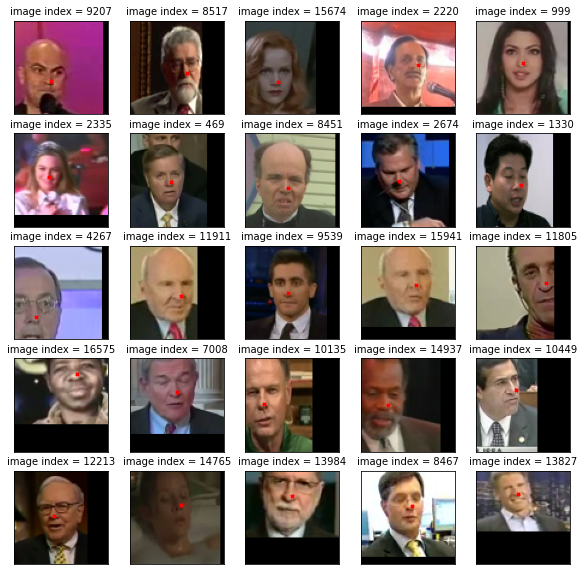

In [19]:
plot_faces(X, Y)

### Quick glance at others augumentation methods
#### Mirroring

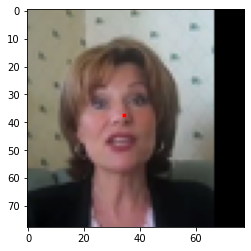

In [20]:
# Example 2
x = X[11, :].astype(np.uint8)
plot_face(x, Y[11, :])

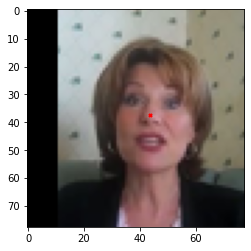

In [21]:
x, coordinates = mirror(x, Y[11, :])
plot_face(x, coordinates)

#### Color shifting

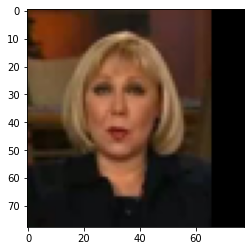

In [22]:
# Example 1
plt.imshow(X[18, :].astype('uint8'))

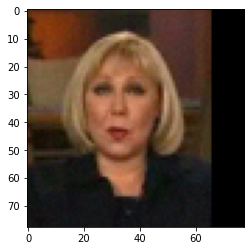

In [23]:
img_arr = shift_colors(X[18, :], shift_range=10)
plt.imshow(img_arr.astype('uint8'))

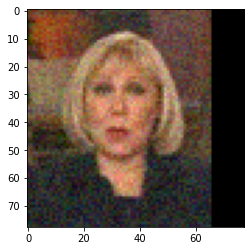

In [24]:
# Extreme example
img_arr = shift_colors(X[18, :], shift_range=50)
plt.imshow(img_arr.astype('uint8'))

## Save data

In [25]:
np.save(os.path.join(data_path, 'X_FK.npy'), X)
np.save(os.path.join(data_path, 'Y_FK.npy'), Y)

In [26]:
# Small data
np.save(os.path.join(data_path, 'X_small.npy'), X[:SMALL_DS_SIZE, :])
np.save(os.path.join(data_path, 'Y_small.npy'), Y[:SMALL_DS_SIZE, :])